In [54]:
import numpy as np
import matplotlib.pyplot as plt
from CardioMesh.CardiacMesh import Cardiac3DMesh

In [55]:
ID = "1000215"

fhm_mesh = Cardiac3DMesh(
    filename=f"/home/rodrigo/01_repos/CardiacCOMA/data/cardio/meshes/by_id/{ID}/models/FHM_time001.npy",
    faces_filename="/home/rodrigo/01_repos/CardioMesh/data/faces_fhm_10pct_decimation.csv",
    subpart_id_filename="/home/rodrigo/01_repos/CardioMesh/data/subpartIDs_FHM_10pct.txt"
)

lv_subparts = ("LV")
lv_mesh = fhm_mesh["LV"]

point_cloud = lv_mesh.v

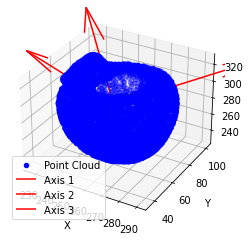

In [292]:
# # Create a 3D scatter plot of the point cloud
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], c='b', marker='o', label='Point Cloud')
# 
# # Scale factor for the axes (adjust this as needed for visibility)
# scale_factor = 100.0
# 
# # Plot the principal inertia axes
# for i in range(3):
#     axis_vector = principal_axes[:, i] * scale_factor
#     ax.quiver(mean[0], mean[1], mean[2], axis_vector[0], axis_vector[1], axis_vector[2], color='r', label=f'Axis {i+1}')
# 
# # Adjust plot limits if needed
# # ax.set_xlim(mean[0] - 3, mean[0] + 3)
# # ax.set_ylim(mean[1] - 3, mean[1] + 3)
# # ax.set_zlim(mean[2] - 3, mean[2] + 3)
# 
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.legend()
# plt.show()

In [431]:
def rotate_vector(vector, axis, angle_degrees):
    # Convert the angle from degrees to radians
    angle_radians = np.radians(angle_degrees)
    
    # Normalize the input vectors
    vector = vector / np.linalg.norm(vector)
    axis = axis / np.linalg.norm(axis)
    
    # Calculate the rotation matrix
    cos_theta = np.cos(angle_radians)
    sin_theta = np.sin(angle_radians)
    rotation_matrix = np.outer(axis, axis) + cos_theta * (np.identity(3) - np.outer(axis, axis)) + sin_theta * np.cross(np.eye(3), axis)
    
    # Apply the rotation to the vector
    rotated_vector = np.dot(rotation_matrix, vector)
    
    return rotated_vector  

In [432]:
# Compute the mean of the point cloud
mean = np.mean(point_cloud, axis=0)

# Subtract the mean from the point cloud to center it
centered_point_cloud = point_cloud - mean

# Compute the covariance matrix
covariance_matrix = np.cov(centered_point_cloud, rowvar=False)

# Compute the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Sort the eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# The eigenvectors represent the principal inertia axes
principal_axes = eigenvectors

In [495]:
### Compute principal inertia axes
v_axis = principal_axes[:, 0] #
h_axis_1 = principal_axes[:, 1] # aligned with aorta
h_axis_2 = principal_axes[:, 2]

####################################################################################################
# HORTIZONTAL PLANES
# Determine the position of the slicing planes along this axis
min_pos = np.min(centered_point_cloud.dot(v_axis))
max_pos = np.max(centered_point_cloud.dot(v_axis))
slice_thickness = (max_pos - min_pos) / (num_slices-1)
fractions = [ -0.01, 0.1, 0.3, 0.5, 0.75, 1.01 ]
num_slices = len(fractions) - 1  
slice_positions = [ min_pos+fraction*(max_pos-min_pos) for fraction in fractions ]

condition_slice = {}
for j in range(num_slices):
    # Classify points based on which side of the slicing plane they fall
    above_plane = centered_point_cloud.dot(v_axis) > slice_positions[j]
    below_plane = centered_point_cloud.dot(v_axis) < slice_positions[j+1]
    condition_slice[j] = above_plane & below_plane

In [513]:
####################################################################################################    
N = 6
# angles = [ (0.5+j)*(360/N) for j in range(N+1) ]
angles = [ (3.5+j)*(360/N) for j in range(N+1) ]
horizontal_axes = [ rotate_vector(h_axis_1, -v_axis, angle) for angle in angles ]

# Create sectors
condition_sec_hex_1 = {}
for j in range(N):
    # Classify points based on which side of the slicing plane they fall
    new_mean = slicewise_mean[3] - mean
    kk = centered_point_cloud - new_mean
    above_plane = kk.dot(horizontal_axes[j]) > 0 # slice_positions[j]
    below_plane = kk.dot(horizontal_axes[j+1]) < 0 # slice_positions[j+1]
    condition_sec_hex_1[j] = above_plane & below_plane
    
condition_sec_hex_2 = {}
for j in range(N):
    # Classify points based on which side of the slicing plane they fall
    
    new_mean = slicewise_mean[2] - mean
    kk = centered_point_cloud - new_mean
    above_plane = kk.dot(horizontal_axes[j]) > 0 # slice_positions[j]
    below_plane = kk.dot(horizontal_axes[j+1]) < 0 # slice_positions[j+1]
    condition_sec_hex_2[j] = above_plane & below_plane
    
####################################################################################################
N = 4    
angles = [ (2.2+j)*(360/N) for j in range(N+1) ]
horizontal_axes = [ rotate_vector(h_axis_1, -v_axis, angle) for angle in angles ]

condition_sec_quart = {}
for j in range(N):
    # Classify points based on which side of the slicing plane they fall
    new_mean = slicewise_mean[1] - mean
    kk = centered_point_cloud - new_mean
    above_plane = kk.dot(horizontal_axes[j]) > 0
    below_plane = kk.dot(horizontal_axes[j+1]) < 0
    condition_sec_quart[j] = above_plane & below_plane  

In [514]:
slicewise_mean = []
for slice in range(5):
    slicewise_mean.append(point_cloud[condition_slice[slice]].mean(0))

In [515]:
AHA_segments_conditions = {
    1: condition_slice[3] & condition_sec_hex_1[0],
    2: condition_slice[3] & condition_sec_hex_1[1],
    3: condition_slice[3] & condition_sec_hex_1[2],
    4: condition_slice[3] & condition_sec_hex_1[3],
    5: condition_slice[3] & condition_sec_hex_1[4],
    6: condition_slice[3] & condition_sec_hex_1[5],
    7: condition_slice[2] & condition_sec_hex_2[0],
    8: condition_slice[2] & condition_sec_hex_2[1],
    9: condition_slice[2] & condition_sec_hex_2[2],
    10: condition_slice[2] & condition_sec_hex_2[3],
    11: condition_slice[2] & condition_sec_hex_2[4],
    12: condition_slice[2] & condition_sec_hex_2[5],
    13: condition_slice[1] & condition_sec_quart[0],
    14: condition_slice[1] & condition_sec_quart[1],
    15: condition_slice[1] & condition_sec_quart[2],
    16: condition_slice[1] & condition_sec_quart[3],
    17: condition_slice[0]
}

Let's split the heart's vertices into different sections

In [516]:
# Visualize the slices (for example, plot them)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'purple', 'orange', 'pink']

colors = [
    'b', 'moccasin', 'r', 'c', 'm', 'y',                        # 1-6
    'k', 'g', 'steelblue', '#FF5733', 'indigo', 'purple',       # 7-12
    'salmon', 'lime', 'lightcoral', 'darkviolet',               # 13-16
    'b'                                                         # 17
]


In [522]:
aha_labels = np.zeros(point_cloud.shape[0])
for segment, condition in AHA_segments_conditions.items():
    aha_labels[condition] = segment

In [523]:
import meshio

meshio.write_points_cells(
    "mesh_with_aha_segments.vtk",
    lv_mesh.points,
    cells={"triangle": np.array(lv_mesh.f)},
    point_data={"subpartID": aha_labels},
)

In [520]:
layers = {    
  1: [17],
  2: list(range(13, 17)),
  3: list(range(7, 13)),
  4: list(range(1, 7)),
}

@interact
def plot_layer(layer=widgets.Select(options=layers)):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='rectilinear')
    
    for segment  in layer:
        
        condition = AHA_segments_conditions[segment]
        slice_points = point_cloud[condition] # slice_points.copy()
        # print(f"{segment}: {slice_points.shape}, {colors[segment-1]} ")
        # slice_points = slice_points[slice_points.dot(v_axis) < (min_pos + (max_pos - min_pos)*0.3) ]
        ax.scatter(
            slice_points[:, 0], slice_points[:, 1], 
            # slice_points[:, 2], 
            c=colors[segment-1], marker='o', label=f'Slice {segment}',
            s=10, alpha=0.8
        )
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    # ax.set_zlabel('Z')
    ax.legend()
    return print(fig)
    

interactive(children=(Select(description='layer', options={1: [17], 2: [13, 14, 15, 16], 3: [7, 8, 9, 10, 11, …

In this code:

- We calculate the direction vectors of the first and second principal axes.
- We specify the rotation angles in degrees.
- We perform the rotations of the second axis using rotation matrices.
- We create planes using the rotated normal vectors and visualize them.

This code will create six planes by rotating the second principal axis with respect to the first axis by the specified angles and display them along with the original point cloud. You can adjust the parameters, such as the number of points in the planes, to suit your visualization needs.


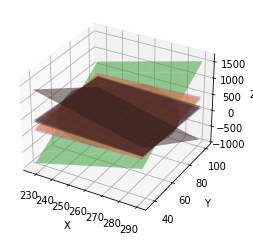

In [504]:
# Define the rotation angles in degrees
rotation_angles = [60, 120, 180, 240, 300, 360]

# Initialize a list to store the rotated plane normals
rotated_normals = []

# Calculate the direction vectors of the first, second, and third principal axes
first_axis = principal_axes[:, 0]
second_axis = principal_axes[:, 1]
third_axis = principal_axes[:, 2]

# Perform rotations and create planes
for angle in rotation_angles:
    # Convert angle from degrees to radians
    angle_rad = np.radians(angle)
    
    # Calculate the rotation matrix in the plane formed by the second and third axes
    rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad), 0],
                                 [np.sin(angle_rad), np.cos(angle_rad), 0],
                                 [0, 0, 1]])
    
    # Rotate the second axis and project it onto the plane formed by the second and third axes
    rotated_second_axis = np.dot(rotation_matrix, second_axis)
    rotated_second_axis -= np.dot(rotated_second_axis, third_axis) * third_axis
    
    # Append the rotated second axis as a normal vector for the plane
    rotated_normals.append(rotated_second_axis)

# Visualize the planes (for example, plot them)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the original point cloud in gray
ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], c='gray', marker='o', label='Point Cloud')

# Plot the planes
for i, normal in enumerate(rotated_normals):
    d = -np.dot(normal, mean)  # Calculate the distance to the plane
    xx, yy = np.meshgrid(np.linspace(min(point_cloud[:, 0]), max(point_cloud[:, 0]), 10),
                         np.linspace(min(point_cloud[:, 1]), max(point_cloud[:, 1]), 10))
    zz = (-normal[0] * xx - normal[1] * yy - d) * 1.0 / normal[2]
    ax.plot_surface(xx, yy, zz, color=f'C{i}', alpha=0.5, label=f'Plane {i+1}')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.legend()
plt.show()

#### Testing with ellipsoid

In [158]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of points on the ellipsoid's surface
num_points = 1000

# Define the radii of the ellipsoid along its principal axes
a = 1.0  # Semi-major axis along the x-axis
b = 1.0  # Semi-major axis along the y-axis
c = 10.0  # Semi-major axis along the z-axis

# Create an array of parameter values (theta and phi)
theta = np.linspace(0, 2 * np.pi, num_points)
phi = np.linspace(0, np.pi, num_points)

# Create a grid of theta and phi values
theta, phi = np.meshgrid(theta, phi)

# Compute the Cartesian coordinates of points on the ellipsoid's surface
x = a * np.sin(phi) * np.cos(theta)
y = b * np.sin(phi) * np.sin(theta)
z = c * np.cos(phi)

# Define rotation angles for tilting the ellipsoid (in radians)
tilt_angle_x = np.radians(0)  # Tilt along the x-axis
tilt_angle_y = np.radians(0)  # Tilt along the y-axis

# Define the rotation matrices for the x and y-axis tilts
rotation_matrix_x = np.array(
    [[1, 0, 0],
    [0, np.cos(tilt_angle_x), -np.sin(tilt_angle_x)],
    [0, np.sin(tilt_angle_x), np.cos(tilt_angle_x)]]
)

rotation_matrix_y = np.array(
    [[np.cos(tilt_angle_y), 0, np.sin(tilt_angle_y)],
    [0, 1, 0],
    [-np.sin(tilt_angle_y), 0, np.cos(tilt_angle_y)]]
)

# Apply the rotation matrices to tilt the ellipsoid
rotated_points = np.dot(
    rotation_matrix_y, 
    np.dot(
        rotation_matrix_x, 
        np.column_stack((x.ravel(), y.ravel(), z.ravel())).T
    )
).T


In [163]:
# Assuming you have a point cloud represented as a NumPy array called 'point_cloud'
# Each row of 'point_cloud' should be a 3D point [x, y, z]

point_cloud = rotated_points
# Compute the mean of the point cloud
mean = np.mean(point_cloud, axis=0)

# Subtract the mean from the point cloud to center it
centered_point_cloud = point_cloud - mean

# Compute the covariance matrix
covariance_matrix = np.cov(centered_point_cloud, rowvar=False)

# Compute the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Sort the eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# The eigenvectors represent the principal inertia axes
principal_axes = eigenvectors

# Print the principal inertia axes
print("Principal Inertia Axes:")
print(principal_axes)

Principal Inertia Axes:
[[-5.87178669e-19  1.00000000e+00 -2.64545511e-15]
 [-4.56684823e-16  0.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00 -1.37044461e-17]]


/tmp/ipykernel_79376/2337522867.py:19: RuntimeWarning: divide by zero encountered in divide
  zz = (-axis[0] * xx - axis[1] * yy - d) * 1.0 / axis[2]


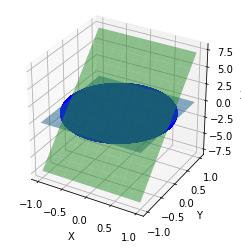

In [164]:
# Visualize the points on the tilted ellipsoid's surface with isotropic scaling
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set isotropic scaling for the axes
ax.set_box_aspect([1, 1, 1])  # Equal scale along all three axes

ax.scatter(rotated_points[:, 0], rotated_points[:, 1], rotated_points[:, 2], c='b', marker='o', s=10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Plot the planes defined by the principal axes
for i, axis in enumerate(principal_axes.T):
    d = -np.dot(axis, mean)  # Calculate the distance to the plane
    xx, yy = np.meshgrid(np.linspace(min(rotated_points[:, 0]), max(rotated_points[:, 0]), 10),
                         np.linspace(min(rotated_points[:, 1]), max(rotated_points[:, 1]), 10))
    zz = (-axis[0] * xx - axis[1] * yy - d) * 1.0 / axis[2]
    ax.plot_surface(xx, yy, zz, color=f'C{i}', alpha=0.5, label=f'Plane {i+1}')
    

# ax.legend()
plt.show()

In this code:

    We compute the mean of the point cloud and subtract it from each point to center the data.
    We calculate the covariance matrix of the centered point cloud.
    We use NumPy's linalg.eig function to compute the eigenvalues and eigenvectors of the covariance matrix.
    We sort the eigenvalues and their corresponding eigenvectors in descending order to get the principal axes.

The principal_axes variable will contain the three principal inertia axes. Each column of principal_axes represents one of the axes as a 3D vector.